# Optimizing AI Trading Algorithms - Course Project


In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [1]:
!pip install --upgrade pip yfinance ta --quiet

  DEPRECATION: ta is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


In [3]:
xlv_data = pd.read_csv('xlv_data.csv')

Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


In [4]:
xlv_data.head()

Date       Open       High        Low      Close  Adj Close  Volume
0  2004-01-02  30.200001  30.440001  30.120001  30.219999  21.567184  628700
1  2004-01-05  30.400000  30.500000  30.139999  30.360001  21.667091  191500
2  2004-01-06  30.469999  30.480000  30.309999  30.450001  21.731337  289300
3  2004-01-07  30.450001  30.639999  30.309999  30.639999  21.866926  262300
4  2004-01-08  30.700001  30.700001  30.320000  30.510000  21.774158  214300

In [5]:
xlv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5094 non-null   object 
 1   Open       5094 non-null   float64
 2   High       5094 non-null   float64
 3   Low        5094 non-null   float64
 4   Close      5094 non-null   float64
 5   Adj Close  5094 non-null   float64
 6   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 278.7+ KB


In [6]:
xlv_data.describe()

Open         High          Low        Close    Adj Close  \
count  5094.000000  5094.000000  5094.000000  5094.000000  5094.000000   
mean     65.342311    65.730397    64.924197    65.349097    58.242299   
std      36.695351    36.915853    36.477869    36.712468    37.932219   
min      22.010000    22.290001    21.629999    21.879999    16.812475   
25%      31.990000    32.132501    31.812500    31.990000    24.508568   
50%      57.100000    57.400000    56.680000    57.010000    48.387001   
75%      90.657503    91.077497    89.927500    90.557499    82.941315   
max     147.919998   148.270004   147.679993   147.860001   147.729996   

             Volume  
count  5.094000e+03  
mean   7.228951e+06  
std    5.445803e+06  
min    5.870000e+04  
25%    3.790550e+06  
50%    6.582850e+06  
75%    9.559550e+06  
max    6.647020e+07

How many `NaN` rows are there in `xlv_data`?


In [7]:
xlv_data.isna().sum().sum()

np.int64(0)

<!-- answer = ## YOUR CODE HERE ## -->
answer = 0

Take a look at the final five rows of `xlv_data`.


In [8]:
xlv_data.tail()

Date        Open        High         Low       Close   Adj Close  \
5089  2024-03-22  145.850006  146.220001  145.259995  145.440002  145.440002   
5090  2024-03-25  145.710007  145.860001  145.009995  145.240005  145.240005   
5091  2024-03-26  145.529999  145.940002  145.139999  145.770004  145.770004   
5092  2024-03-27  147.009995  147.710007  146.619995  147.710007  147.710007   
5093  2024-03-28  147.919998  148.229996  147.679993  147.729996  147.729996   

       Volume  
5089  5537200  
5090  5253000  
5091  6942400  
5092  8797400  
5093  8090200

Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


In [9]:
xlv_data["Date"] = pd.to_datetime(xlv_data["Date"])
xlv_data.set_index("Date", inplace=True)

**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


In [10]:
data_since_2023 = xlv_data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [11]:
vix_data = pd.read_csv('vix_data.csv')

In [12]:
vix_data.head()

Date       Open   High        Low      Close  Adj Close  Volume
0  2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
1  2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0
2  2004-01-06  17.660000  17.67  16.190001  16.730000  16.730000       0
3  2004-01-07  16.719999  16.75  15.500000  15.500000  15.500000       0
4  2004-01-08  15.420000  15.68  15.320000  15.610000  15.610000       0

In [13]:
vix_data.tail()

Date   Open   High    Low  Close  Adj Close  Volume
5089  2024-03-22  12.92  13.15  12.58  13.06      13.06       0
5090  2024-03-25  13.67  13.67  13.11  13.19      13.19       0
5091  2024-03-26  13.12  13.43  12.84  13.24      13.24       0
5092  2024-03-27  13.13  13.34  12.66  12.78      12.78       0
5093  2024-03-28  12.93  13.10  12.84  13.01      13.01       0

In [14]:
vix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5094 non-null   object 
 1   Open       5094 non-null   float64
 2   High       5094 non-null   float64
 3   Low        5094 non-null   float64
 4   Close      5094 non-null   float64
 5   Adj Close  5094 non-null   float64
 6   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 278.7+ KB


In [15]:
vix_data.describe()

Open         High          Low        Close    Adj Close  Volume
count  5094.000000  5094.000000  5094.000000  5094.000000  5094.000000  5094.0
mean     19.216993    20.155163    18.281728    19.082091    19.082091     0.0
std       8.782565     9.442302     8.095060     8.730636     8.730636     0.0
min       9.010000     9.310000     8.560000     9.140000     9.140000     0.0
25%      13.490000    14.020000    12.980000    13.390000    13.390000     0.0
50%      16.629999    17.425000    15.930000    16.535001    16.535001     0.0
75%      22.277501    23.367501    21.240000    22.090000    22.090000     0.0
max      82.690002    89.529999    72.760002    82.690002    82.690002     0.0

In [16]:
vix_data["Date"] = pd.to_datetime(vix_data["Date"])

In [17]:
vix =  vix_data.copy()

In [18]:
vix.set_index("Date", inplace=True)

In [19]:
vix.head(2)

Open   High        Low      Close  Adj Close  Volume
Date                                                                 
2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0

In [20]:
data_since_2023 = vix["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


In [21]:
vix_data.head(2)

Date       Open   High        Low      Close  Adj Close  Volume
0 2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
1 2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0

In [22]:
vix.head(2)

Open   High        Low      Close  Adj Close  Volume
Date                                                                 
2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0

In [23]:
# Plot line chart with Plotly
fig = px.line(vix_data, x=vix_data.index, y="Adj Close", title="VIX Adjusted Close Over Time")
fig.update_layout(xaxis_title="Date", yaxis_title="Adjusted Close")
fig.show()


### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [24]:
google_trends_data = pd.read_csv('GoogleTrendsData.csv')
google_trends_data.head()

Month  recession_search_trend
0  2004-01                       4
1  2004-02                       4
2  2004-03                       5
3  2004-04                       6
4  2004-05                       4

As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [25]:
google_trends_data.index

RangeIndex(start=0, stop=243, step=1)

In [26]:
google_trends_data.tail()

Month  recession_search_trend
238  2023-11                      16
239  2023-12                      13
240  2024-01                      12
241  2024-02                      16
242  2024-03                      13

In [27]:
google_trends_data.index

RangeIndex(start=0, stop=243, step=1)

We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [28]:
if isinstance(google_trends_data.index, pd.DatetimeIndex):
    print("Index is a DatetimeIndex.")
else:
    print("Index is NOT a DatetimeIndex. Converting now...")
    google_trends_data.index = pd.to_datetime(google_trends_data.index)
    print("Index successfully converted to DatetimeIndex.")


Index is NOT a DatetimeIndex. Converting now...
Index successfully converted to DatetimeIndex.


In [29]:
google_trends_data['Month'] = pd.to_datetime(google_trends_data['Month'])  # Convert 'Month' to datetime
google_trends_data.set_index('Month', inplace=True)  # Set 'Month' as index

In [30]:
if isinstance(google_trends_data.index, pd.DatetimeIndex):
    print("Index is a DatetimeIndex.")
else:
    print("Index is NOT a DatetimeIndex. Converting now...")
    google_trends_data.index = pd.to_datetime(google_trends_data.index)
    print("Index successfully converted to DatetimeIndex.")


Index is a DatetimeIndex.


In [31]:
google_trends_data.head()

recession_search_trend
Month                             
2004-01-01                       4
2004-02-01                       4
2004-03-01                       5
2004-04-01                       6
2004-05-01                       4

In [32]:
# Shift the index to the last day of the respective months
google_trends_data.index = google_trends_data.index + pd.offsets.MonthEnd()

Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


In [33]:
type(google_trends_data)

pandas.core.frame.DataFrame

In [34]:
google_trends_data.head()

recession_search_trend
Month                             
2004-01-31                       4
2004-02-29                       4
2004-03-31                       5
2004-04-30                       6
2004-05-31                       4

In [35]:
google_trends_data.columns

Index(['recession_search_trend'], dtype='object')

In [36]:
print(google_trends_data.info())
print(google_trends_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2004-01-31 to 2024-03-31
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   recession_search_trend  243 non-null    int64
dtypes: int64(1)
memory usage: 3.8 KB
None
            recession_search_trend
Month                             
2004-01-31                       4
2004-02-29                       4
2004-03-31                       5
2004-04-30                       6
2004-05-31                       4


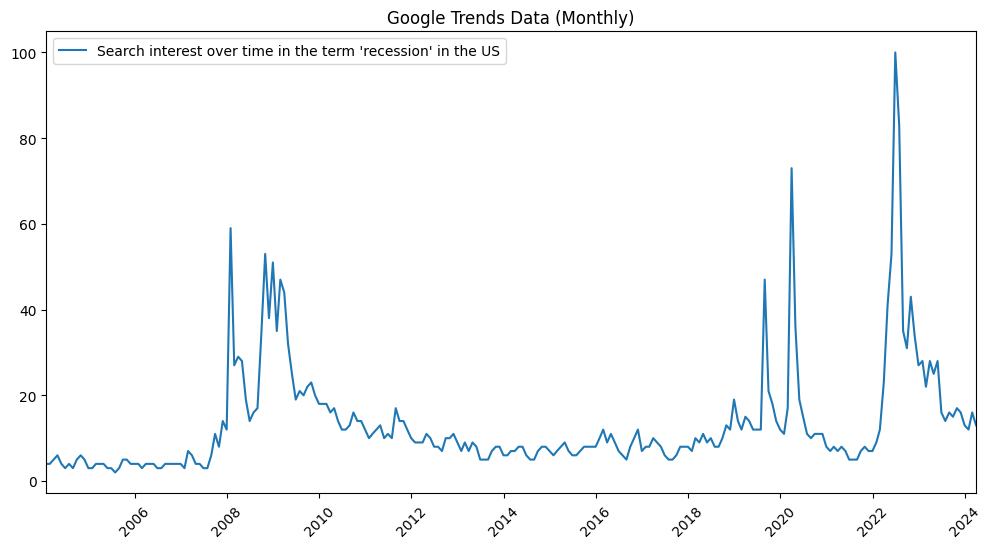

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [38]:
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')

In [39]:
# # The shape of the chart should not have changed
# google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
#     labels=['Search interest over time in the term "recession" in the US']
# );

## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [40]:
# Assuming XLV data is stored in `xlv_data`, and its index is a DatetimeIndex.
data = pd.DataFrame(index=xlv_data.index)

# Check if the index matches XLV's index
data.head()

Empty DataFrame
Columns: []
Index: [2004-01-02 00:00:00, 2004-01-05 00:00:00, 2004-01-06 00:00:00, 2004-01-07 00:00:00, 2004-01-08 00:00:00]

### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [41]:
# Adding the month and weekday columns
data['Month'] = data.index.month  # Extract month as an integer (1-12)
data['Weekday'] = data.index.weekday  # Extract weekday as an integer (0=Monday, 6=Sunday)

# Check the resulting data
data.head()


Month  Weekday
Date                      
2004-01-02      1        4
2004-01-05      1        0
2004-01-06      1        1
2004-01-07      1        2
2004-01-08      1        3

You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [42]:
# Assuming `data` already has the 'Month' and 'Weekday' columns

# Treat month as a cyclical feature with a period of 12 months
data['month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Drop the original month column
data.drop(columns=['Month'], inplace=True)

# One-hot encode the weekday column
data = pd.get_dummies(data, columns=['Weekday'], prefix='weekday', dtype='int32')

# Check the resulting data
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  
Date                   
2004-01-02          1  
2004-01-05          0  
2004-01-06          0  
2004-01-07          0  
2004-01-08          0

#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [43]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]

In [44]:
hist_ret_lookbacks

[1, 5, 10, 20]

In [45]:
# data.head()

In [46]:
data.columns

Index(['month_sin', 'month_cos', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4'],
      dtype='object')

In [47]:
# Assuming xlv_data is your DataFrame with the 'Adj Close' column
# Merge the 'Adj Close' from xlv_data into your 'data' DataFrame on the index (datetime)
data = data.merge(xlv_data[['Adj Close']], left_index=True, right_index=True, how='left')

In [48]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  
Date                              
2004-01-02          1  21.567184  
2004-01-05          0  21.667091  
2004-01-06          0  21.731337  
2004-01-07          0  21.866926  
2004-01-08          0  21.774158

In [49]:
# Now you can calculate the rolling returns based on 'Adj Close'
for lookback in hist_ret_lookbacks:
    data[f'ret_{lookback}d_hist'] = data['Adj Close'].pct_change(periods=lookback)

In [50]:
data.columns

Index(['month_sin', 'month_cos', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'Adj Close', 'ret_1d_hist', 'ret_5d_hist',
       'ret_10d_hist', 'ret_20d_hist'],
      dtype='object')

In [51]:
# Check the resulting DataFrame
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  
Date                      
2004-01-02           NaN  
2004-01-05           NaN  
2004-01-06           NaN  
2004-01-07           NaN  
2004-01-08           NaN

The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


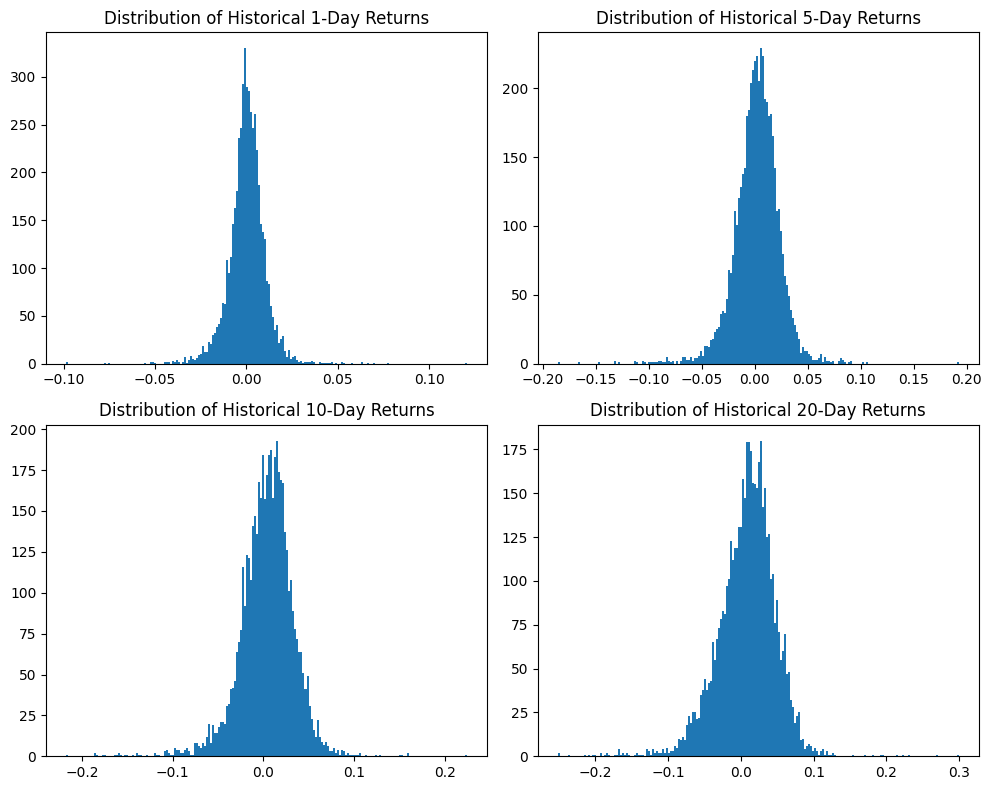

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)


for i, n_days in enumerate(hist_ret_lookbacks):
    plot_hist_returns(
        axs[i // 2, i % 2], data, f"ret_{n_days}d_hist", f"Distribution of Historical {n_days}-Day Returns"
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [53]:
xlv_data.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2004-01-02  30.200001  30.440001  30.120001  30.219999  21.567184  628700
2004-01-05  30.400000  30.500000  30.139999  30.360001  21.667091  191500
2004-01-06  30.469999  30.480000  30.309999  30.450001  21.731337  289300
2004-01-07  30.450001  30.639999  30.309999  30.639999  21.866926  262300
2004-01-08  30.700001  30.700001  30.320000  30.510000  21.774158  214300

In [54]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  
Date                      
2004-01-02           NaN  
2004-01-05           NaN  
2004-01-06           NaN  
2004-01-07           NaN  
2004-01-08           NaN

In [55]:
# Merge the 'Adj Close' from xlv_data into the 'data' DataFrame on the index (datetime)
data = data.merge(xlv_data[['Volume']], left_index=True, right_index=True, how='left')

In [56]:
data = data.merge(xlv_data[['High']], left_index=True, right_index=True, how='left')
data = data.merge(xlv_data[['Low']], left_index=True, right_index=True, how='left')

In [57]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  Volume       High        Low  
Date                                                    
2004-01-02           NaN  628700  30.440001  30.120001  
2004-01-05           NaN  191500  30.500000  30.139999  
2004-01-06           NaN  289300  30.480000  30.309999  
2004-01-07           NaN  262300  30.639999  30.309999  
2004-01-08           NaN  214300  30.700001  30.320000

In [58]:
# data["log_volume"] = ## YOUR CODE HERE ##
# Ensure volume has no zero values to avoid log issues
data['log_volume'] = np.log(data['Volume'].replace(0, np.nan))

In [59]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  Volume       High        Low  log_volume  
Date                                                                
2004-01-02           NaN  628700  30.440001  30.120001   13.351409  
2004-01-05           NaN  191500  30.500000  30.139999   12.162643  
2004-01-06           NaN  289300  30.480000  30.309999   12.575219  
2004-01-07           NaN  262300  30.639999  30.309999   12.477244  
2004-01-08           NaN  214300  30.700001  30.320000   12.275132

#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [60]:
# Merge the 'Adj Close' from xlv_data into your 'data' DataFrame on the index (datetime)
data = data.merge(xlv_data[['Close']], left_index=True, right_index=True, how='left')

In [61]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) from XLV's price data
# data["ibs"] = ## YOUR CODE HERE ##

# Ensure no division by zero in case High == Low
data['ibs'] = (data['Close'] - data['Low']) / (data['High'] - data['Low']).replace(0, np.nan)

Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [62]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [63]:
# Calculate the 5-day forward simple return
data['return_5d_fut'] = data['Adj Close'].pct_change(5).shift(-5)

# Create the target column: 1 if future return is positive, otherwise 0
data['tgt_is_pos_ret_5d_fut'] = (data['return_5d_fut'] > 0).astype(int)

# Drop intermediate return column if not needed
data.drop(columns=['return_5d_fut'], inplace=True)


Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [64]:
target_col_name = "tgt_is_pos_ret_5d_fut"
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)


tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

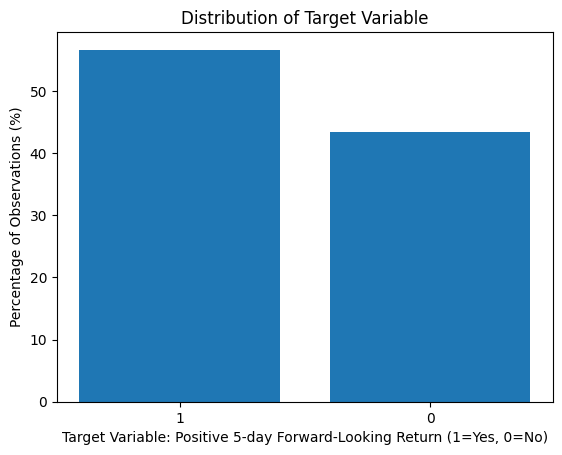

In [65]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


answer:

target variable tgt_is_pos_ret_5d_fut has the following distribution:

1 (Positive 5-day future return): 56.6%
0 (Negative 5-day future return): 43.4%

This is relatively balanced since the difference between the two classes is not extreme. Generally:

A dataset is considered imbalanced if one class is significantly below 40% or above 60%.
The dataset is slightly skewed toward positive returns but not severely imbalanced enough to require drastic adjustments.

Since the imbalance is minor, most machine learning models will handle it without requiring special techniques like resampling or class weighting.

However, metrics beyond accuracy (such as precision, recall, and F1-score) are still useful to ensure the model is learning both classes well.

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [66]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  Volume       High        Low  log_volume      Close  \
Date                                                                            
2004-01-02           NaN  628700  30.440001  30.120001   13.351409  30.219999   
2004-01-05           NaN  191500  30.500000  30.139999   12.162643  30.360001   
2004-01-06           NaN  289300  30.480000  30.309999   12.575219  30.450001   
2004-01-07           NaN  262300  30.639999  30.309999   12.477244  30.639999   
2004-01-08           NaN  214300  30.700001  30.320000   12.275132  30.510000   

                 ibs  bb_bbm  bb_bbh  bb_bbl  bb_bbhi  bb_bbli  bb_bbw  \
Date                                                                     
2004-01-02  0.312496     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-05  0.611113     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-06  0.823537     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-07  1.000000     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-08  0.500000     NaN     NaN     NaN      0.0      0.0     NaN   

            bb_bbp  rsi  tgt_is_pos_ret_5d_fut  
Date                                            
2004-01-02     NaN  NaN                      1  
2004-01-05     NaN  NaN                      0  
2004-01-06     NaN  NaN                      0  
2004-01-07     NaN  NaN                      0  
2004-01-08     NaN  NaN                      0

In [67]:
vix_data.head()

Date       Open   High        Low      Close  Adj Close  Volume
0 2004-01-02  17.959999  18.68  17.540001  18.219999  18.219999       0
1 2004-01-05  18.450001  18.49  17.440001  17.490000  17.490000       0
2 2004-01-06  17.660000  17.67  16.190001  16.730000  16.730000       0
3 2004-01-07  16.719999  16.75  15.500000  15.500000  15.500000       0
4 2004-01-08  15.420000  15.68  15.320000  15.610000  15.610000       0

In [68]:
google_trends_daily.head()

recession_search_trend
Month                             
2004-01-31                     4.0
2004-02-01                     4.0
2004-02-02                     4.0
2004-02-03                     4.0
2004-02-04                     4.0

In [69]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")

In [70]:
data.head()

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02        0.5   0.866025          0          0          0          0   
2004-01-05        0.5   0.866025          1          0          0          0   
2004-01-06        0.5   0.866025          0          1          0          0   
2004-01-07        0.5   0.866025          0          0          1          0   
2004-01-08        0.5   0.866025          0          0          0          1   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   

            ret_20d_hist  Volume       High        Low  log_volume      Close  \
Date                                                                            
2004-01-02           NaN  628700  30.440001  30.120001   13.351409  30.219999   
2004-01-05           NaN  191500  30.500000  30.139999   12.162643  30.360001   
2004-01-06           NaN  289300  30.480000  30.309999   12.575219  30.450001   
2004-01-07           NaN  262300  30.639999  30.309999   12.477244  30.639999   
2004-01-08           NaN  214300  30.700001  30.320000   12.275132  30.510000   

                 ibs  bb_bbm  bb_bbh  bb_bbl  bb_bbhi  bb_bbli  bb_bbw  \
Date                                                                     
2004-01-02  0.312496     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-05  0.611113     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-06  0.823537     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-07  1.000000     NaN     NaN     NaN      0.0      0.0     NaN   
2004-01-08  0.500000     NaN     NaN     NaN      0.0      0.0     NaN   

            bb_bbp  rsi  tgt_is_pos_ret_5d_fut  recession_search_trend  
Date                                                                    
2004-01-02     NaN  NaN                      1                     NaN  
2004-01-05     NaN  NaN                      0                     NaN  
2004-01-06     NaN  NaN                      0                     NaN  
2004-01-07     NaN  NaN                      0                     NaN  
2004-01-08     NaN  NaN                      0                     NaN

### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [71]:
data.isna().sum()

month_sin                  0
month_cos                  0
weekday_0                  0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
Adj Close                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
Volume                     0
High                       0
Low                        0
log_volume                 0
Close                      0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [72]:
data.head(21)

month_sin  month_cos  weekday_0  weekday_1  weekday_2  weekday_3  \
Date                                                                           
2004-01-02   0.500000   0.866025          0          0          0          0   
2004-01-05   0.500000   0.866025          1          0          0          0   
2004-01-06   0.500000   0.866025          0          1          0          0   
2004-01-07   0.500000   0.866025          0          0          1          0   
2004-01-08   0.500000   0.866025          0          0          0          1   
2004-01-09   0.500000   0.866025          0          0          0          0   
2004-01-12   0.500000   0.866025          1          0          0          0   
2004-01-13   0.500000   0.866025          0          1          0          0   
2004-01-14   0.500000   0.866025          0          0          1          0   
2004-01-15   0.500000   0.866025          0          0          0          1   
2004-01-16   0.500000   0.866025          0          0          0          0   
2004-01-20   0.500000   0.866025          0          1          0          0   
2004-01-21   0.500000   0.866025          0          0          1          0   
2004-01-22   0.500000   0.866025          0          0          0          1   
2004-01-23   0.500000   0.866025          0          0          0          0   
2004-01-26   0.500000   0.866025          1          0          0          0   
2004-01-27   0.500000   0.866025          0          1          0          0   
2004-01-28   0.500000   0.866025          0          0          1          0   
2004-01-29   0.500000   0.866025          0          0          0          1   
2004-01-30   0.500000   0.866025          0          0          0          0   
2004-02-02   0.866025   0.500000          1          0          0          0   

            weekday_4  Adj Close  ret_1d_hist  ret_5d_hist  ret_10d_hist  \
Date                                                                       
2004-01-02          1  21.567184          NaN          NaN           NaN   
2004-01-05          0  21.667091     0.004632          NaN           NaN   
2004-01-06          0  21.731337     0.002965          NaN           NaN   
2004-01-07          0  21.866926     0.006239          NaN           NaN   
2004-01-08          0  21.774158    -0.004242          NaN           NaN   
2004-01-09          1  21.638557    -0.006228     0.003309           NaN   
2004-01-12          0  21.602869    -0.001649    -0.002964           NaN   
2004-01-13          0  21.510088    -0.004295    -0.010181           NaN   
2004-01-14          0  21.631409     0.005640    -0.010770           NaN   
2004-01-15          0  21.688509     0.002640    -0.003934           NaN   
2004-01-16          1  21.738464     0.002303     0.004617      0.007942   
2004-01-20          0  21.667091    -0.003283     0.002973      0.000000   
2004-01-21          0  22.031078     0.016799     0.024221      0.013793   
2004-01-22          0  22.073889     0.001943     0.020455      0.009465   
2004-01-23          1  21.966839    -0.004850     0.012833      0.008849   
2004-01-26          0  22.245173     0.012671     0.023309      0.028034   
2004-01-27          0  22.102430    -0.006417     0.020092      0.023125   
2004-01-28          0  21.909744    -0.008718    -0.005507      0.018580   
2004-01-29          0  22.230892     0.014658     0.007113      0.027714   
2004-01-30          1  22.109577    -0.005457     0.006498      0.019414   
2004-02-02          0  22.395033     0.012911     0.006737      0.030203   

            ret_20d_hist  Volume       High        Low  log_volume      Close  \
Date                                                                            
2004-01-02           NaN  628700  30.440001  30.120001   13.351409  30.219999   
2004-01-05           NaN  191500  30.500000  30.139999   12.162643  30.360001   
2004-01-06           NaN  289300  30.480000  30.309999   12.575219  30.450001   
2004-01-07       

In [73]:
# Drop the first 20 rows due to missing values from rolling calculations
data = data.iloc[20:].reset_index(drop=True)

Are there any more missing values?

In [74]:
data.isna().sum()

month_sin                 0
month_cos                 0
weekday_0                 0
weekday_1                 0
weekday_2                 0
weekday_3                 0
weekday_4                 0
Adj Close                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
Volume                    0
High                      0
Low                       0
log_volume                0
Close                     0
ibs                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
tgt_is_pos_ret_5d_fut     0
recession_search_trend    0
dtype: int64

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [75]:
data = data.iloc[:-5]

Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month_sin               5069 non-null   float64
 1   month_cos               5069 non-null   float64
 2   weekday_0               5069 non-null   int32  
 3   weekday_1               5069 non-null   int32  
 4   weekday_2               5069 non-null   int32  
 5   weekday_3               5069 non-null   int32  
 6   weekday_4               5069 non-null   int32  
 7   Adj Close               5069 non-null   float64
 8   ret_1d_hist             5069 non-null   float64
 9   ret_5d_hist             5069 non-null   float64
 10  ret_10d_hist            5069 non-null   float64
 11  ret_20d_hist            5069 non-null   float64
 12  Volume                  5069 non-null   int64  
 13  High                    5069 non-null   float64
 14  Low                     5069 non-null   

In [77]:
data.describe()

month_sin     month_cos    weekday_0    weekday_1    weekday_2  \
count  5.069000e+03  5.069000e+03  5069.000000  5069.000000  5069.000000   
mean  -2.838770e-03 -7.572043e-03     0.186625     0.205169     0.205761   
std    7.097124e-01  7.045852e-01     0.389648     0.403865     0.404296   
min   -1.000000e+00 -1.000000e+00     0.000000     0.000000     0.000000   
25%   -8.660254e-01 -8.660254e-01     0.000000     0.000000     0.000000   
50%   -2.449294e-16 -1.836970e-16     0.000000     0.000000     0.000000   
75%    8.660254e-01  5.000000e-01     0.000000     0.000000     0.000000   
max    1.000000e+00  1.000000e+00     1.000000     1.000000     1.000000   

         weekday_3    weekday_4    Adj Close  ret_1d_hist  ret_5d_hist  \
count  5069.000000  5069.000000  5069.000000  5069.000000  5069.000000   
mean      0.202210     0.200237    58.298999     0.000427     0.002097   
std       0.401687     0.400217    37.855682     0.010493     0.021729   
min       0.000000     0.000000    16.812475    -0.098610    -0.185835   
25%       0.000000     0.000000    24.545486    -0.004458    -0.009204   
50%       0.000000     0.000000    48.842003     0.000633     0.002931   
75%       0.000000     0.000000    82.949326     0.005891     0.014858   
max       1.000000     1.000000   147.328003     0.120547     0.192308   

       ret_10d_hist  ret_20d_hist        Volume         High          Low  \
count   5069.000000   5069.000000  5.069000e+03  5069.000000  5069.000000   
mean       0.004185      0.008346  7.256760e+06    65.788438    64.980507   
std        0.029813      0.040486  5.441358e+06    36.853596    36.414478   
min       -0.217250     -0.251548  5.870000e+04    22.290001    21.629999   
25%       -0.011609     -0.013455  3.830200e+06    32.189999    31.840000   
50%        0.005917      0.011537  6.608700e+06    57.880001    57.029999   
75%        0.021953      0.032932  9.578700e+06    91.110001    89.980003   
max        0.223935      0.299116  6.647020e+07   148.270004   147.339996   

        log_volume        Close          ibs       bb_bbm       bb_bbh  \
count  5069.000000  5069.000000  5069.000000  5069.000000  5069.000000   
mean     15.409240    65.406279     0.534112    65.190507    67.147802   
std       1.081947    36.649774     0.307988    36.490915    37.643799   
min      10.980195    21.879999     0.000000    23.217500    24.569328   
25%      15.158428    32.020000     0.259258    32.040500    32.789038   
50%      15.703898    57.529999     0.546873    57.274000    58.749715   
75%      16.075052    90.570000     0.818179    90.399500    93.205837   
max      18.012264   147.860001     1.000000   146.183501   148.369194   

            bb_bbl      bb_bbhi      bb_bbli       bb_bbw       bb_bbp  \
count  5069.000000  5069.000000  5069.000000  5069.000000  5069.000000   
mean     63.233213     0.060761     0.054054     5.948065     0.567198   
std      35.382734     0.238916     0.226147     3.644471     0.326476   
min      20.419952     0.000000     0.000000     1.165471    -0.452267   
25%      31.152674     0.000000     0.000000     3.790178     0.310053   
50%      54.721044     0.000000     0.000000     5.052307     0.622857   
75%      87.412764     0.000000     0.000000     7.015371     0.832430   
max     144.631724     1.000000     1.000000    32.354816     1.349959   

               rsi  tgt_is_pos_ret_5d_fut  recession_search_trend  
count  5069.000000            5069.000000             5069.000000  
mean     53.683015               0.565989               13.290878  
std      11.253373               0.495675               12.478947  
min      13.539141               0.000000                2.032258  
25%      46.019133               0.000000                6.322581  
50%      54.080883               1.000000                9.225806  
75%      61.812445               1.000000               14.931034  
max      85.413254               1.000000              100.000000

### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [78]:
# import seaborn as sns
# import matplotlib.pyplot as plt

In [79]:
def plot_heatmap(df):
    
    # Compute the correlation matrix
    correlation_matrix = data.corr()

    # Create the heatmap with larger figure and label rotation
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                linewidths=0.5, annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})

    # Rotate the labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, va="center")

    # Display the heatmap
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()  # Ensure everything fits without overlapping
    plt.show()
    

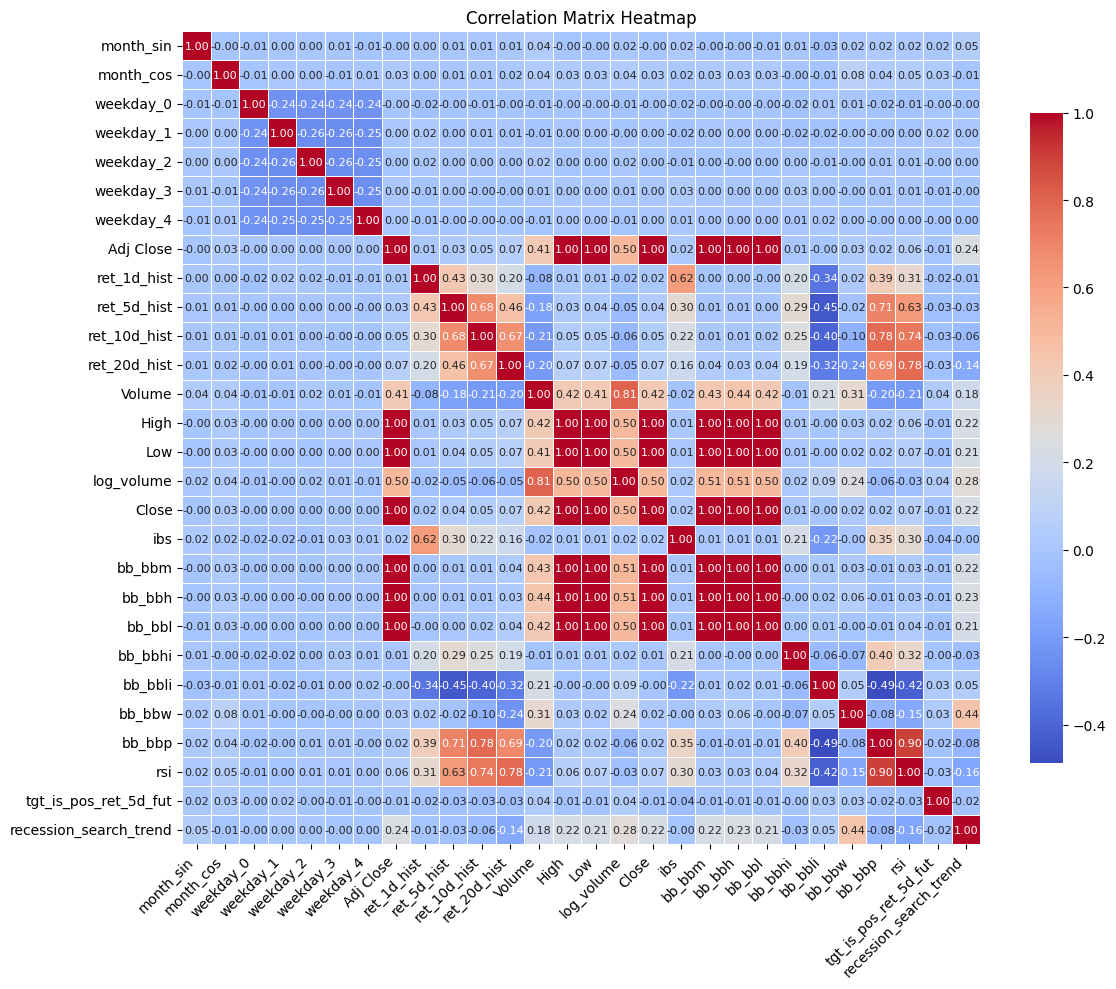

In [80]:
plot_heatmap(data)

In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [81]:
# Check the correlation matrix to find collinear features
correlation_matrix = data.corr()

# Print the correlations with 'bb_bbm' to identify highly correlated features
print(correlation_matrix['bb_bbm'].sort_values(ascending=False))


bb_bbm                    1.000000
bb_bbh                    0.999425
bb_bbl                    0.999349
High                      0.999097
Close                     0.998907
Low                       0.998801
Adj Close                 0.998105
log_volume                0.506006
Volume                    0.427789
recession_search_trend    0.221064
ret_20d_hist              0.037170
rsi                       0.032367
month_cos                 0.032007
bb_bbw                    0.027838
bb_bbli                   0.014076
ret_10d_hist              0.013345
ibs                       0.009885
ret_5d_hist               0.005005
weekday_3                 0.001455
weekday_4                 0.001296
weekday_1                 0.001167
bb_bbhi                   0.000772
ret_1d_hist               0.000555
weekday_2                 0.000004
month_sin                -0.003838
weekday_0                -0.004044
tgt_is_pos_ret_5d_fut    -0.009908
bb_bbp                   -0.012143
Name: bb_bbm, dtype:

In [82]:
# Drop the collinear features (besides 'bb_bbm')
data = data.drop(columns=['bb_bbh', 'bb_bbl'])

# Verify that the features are dropped
data.columns

Index(['month_sin', 'month_cos', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'Adj Close', 'ret_1d_hist', 'ret_5d_hist',
       'ret_10d_hist', 'ret_20d_hist', 'Volume', 'High', 'Low', 'log_volume',
       'Close', 'ibs', 'bb_bbm', 'bb_bbhi', 'bb_bbli', 'bb_bbw', 'bb_bbp',
       'rsi', 'tgt_is_pos_ret_5d_fut', 'recession_search_trend'],
      dtype='object')

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [83]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Identify the feature most highly correlated with RSI (assuming RSI column is named 'rsi')
# Replace 'rsi' with the exact column name if necessary
correlated_features = correlation_matrix['rsi'].drop('rsi').abs().idxmax()

# Drop the highly correlated feature
data.drop(columns=[correlated_features], inplace=True)

print(f"Dropped feature: {correlated_features}")


Dropped feature: bb_bbp


Plot the heatmap of the new, reduced correlation matrix.

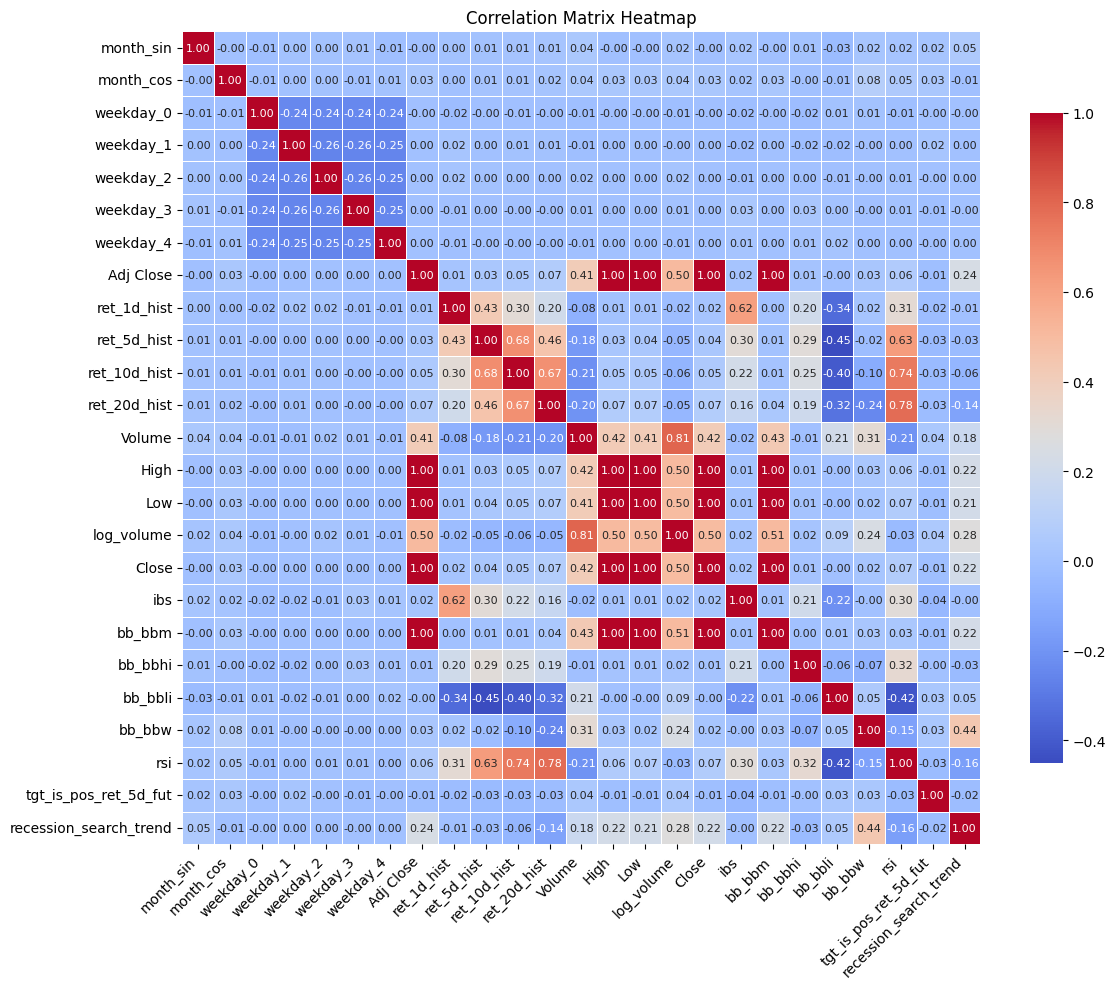

In [84]:
## YOUR CODE HERE ##

plot_heatmap(data)

Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


To find the two independent variables that are correlated by more than 4% (either positively or negatively) with the boolean target variable tgt_is_pos_ret_5d_fut, you can filter the correlation matrix for features that have a correlation of more than 0.04 or less than -0.04 with the target variable.

In [85]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Get the correlations of the features with the target variable (tgt_is_pos_ret_5d_fut)
target_corr = correlation_matrix['tgt_is_pos_ret_5d_fut']

# Filter out features with a correlation higher than 4% (0.04) in either direction
important_features = target_corr[abs(target_corr) > 0.04]

# Display the result
print(important_features)


log_volume               0.043164
ibs                     -0.044293
tgt_is_pos_ret_5d_fut    1.000000
Name: tgt_is_pos_ret_5d_fut, dtype: float64


answer = log_volume has a correlation of 0.043164 with the target variable tgt_is_pos_ret_5d_fut, which is greater than 4%.
ibs has a correlation of -0.044293 with the target variable tgt_is_pos_ret_5d_fut, which is also greater than 4% (in the negative direction).

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [86]:
# Assuming 'data' contains both features (X) and target (y)
X = data.drop(columns=['tgt_is_pos_ret_5d_fut'])  # Independent variables (features)
y = data['tgt_is_pos_ret_5d_fut']  # Dependent variable (target)

# Split the data: first 80% for training + validation, remaining 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Check the shape of the splits
print(f"Training + Validation set: X_train_val: {X_train_val.shape}, y_train_val: {y_train_val.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training + Validation set: X_train_val: (4055, 24), y_train_val: (4055,)
Testing set: X_test: (1014, 24), y_test: (1014,)


### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

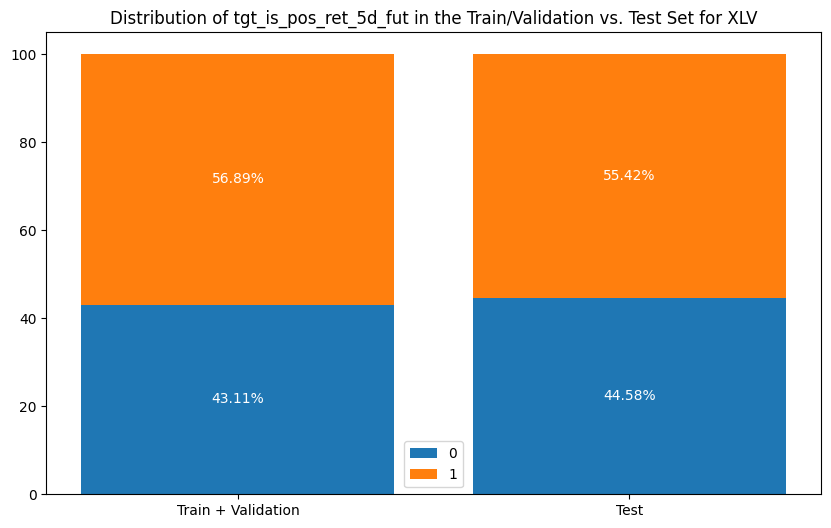

In [87]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

In [88]:
# Find the majority class in the target variable
majority_class = y_train_val.mode()[0]  # This gets the most frequent class in the training+validation set

# Make predictions for both the training+validation and testing sets by always predicting the majority class
y_train_val_pred = [majority_class] * len(y_train_val)
y_test_pred = [majority_class] * len(y_test)

# Calculate the accuracy scores
baseline_accuracy_train_val_score = accuracy_score(y_train_val, y_train_val_pred)
baseline_accuracy_test_score = accuracy_score(y_test, y_test_pred)

# Display the baseline accuracy scores
print(f"Baseline Accuracy (Training + Validation set): {baseline_accuracy_train_val_score:.4f}")
print(f"Baseline Accuracy (Testing set): {baseline_accuracy_test_score:.4f}")


Baseline Accuracy (Training + Validation set): 0.5689
Baseline Accuracy (Testing set): 0.5542


## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [89]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [90]:
max_depth = 10
# max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [91]:
# Define your model (Random Forest is used here as an example)
model = RandomForestClassifier(random_state=42)

# Use learning_curve with 5-fold cross-validation
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_val, y_train_val, 
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    cv=5, 
    scoring='accuracy', 
    random_state=42
)

# Display results
print(f"Train Sizes: {train_sizes}")
print(f"Train Scores: {train_scores}")
print(f"Test Scores: {test_scores}")


Train Sizes: [ 324  648  973 1297 1622 1946 2270 2595 2919 3244]
Train Scores: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Test Scores: [[0.46362515 0.51294698 0.38347719 0.46979038 0.46239211]
 [0.46362515 0.54130703 0.38347719 0.4377312  0.43279901]
 [0.43279901 0.3378545  0.39087546 0.44143033 0.43403206]
 [0.44143033 0.33168927 0.38471023 0.43403206 0.43279901]
 [0.4377312  0.34155364 0.34648582 0.44389642 0.4377312 ]
 [0.46239211 0.33292232 0.33292232 0.43279901 0.43649815]
 [0.43896424 0.33538841 0.33292232 0.55733662 0.55363748]
 [0.44636252 0.33292232 0.35758323 0.50184957 0.43156597]
 [0.43279901 0.33415536 0.351418   0.47225647 0.43649815]
 [0.44512947 0.32675709 0.34155364 0.46732429 0.41307028]]


Inspect the learning curves.

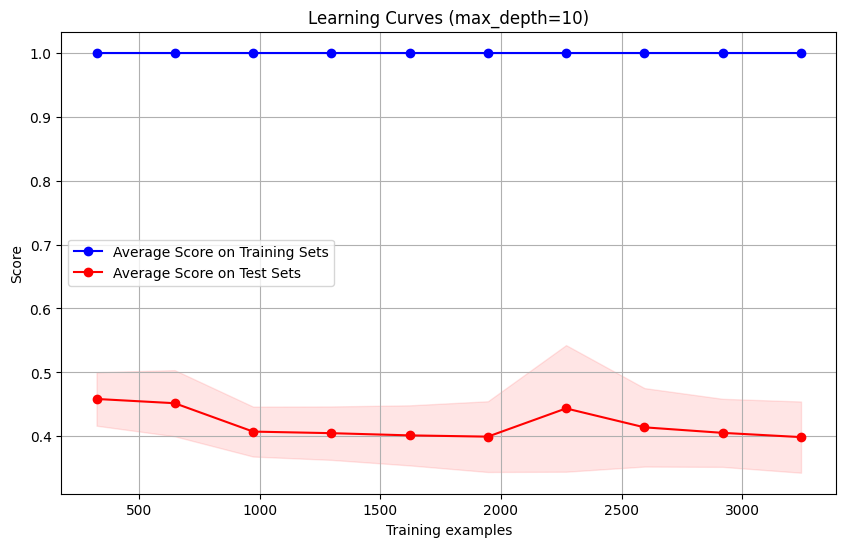

In [92]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


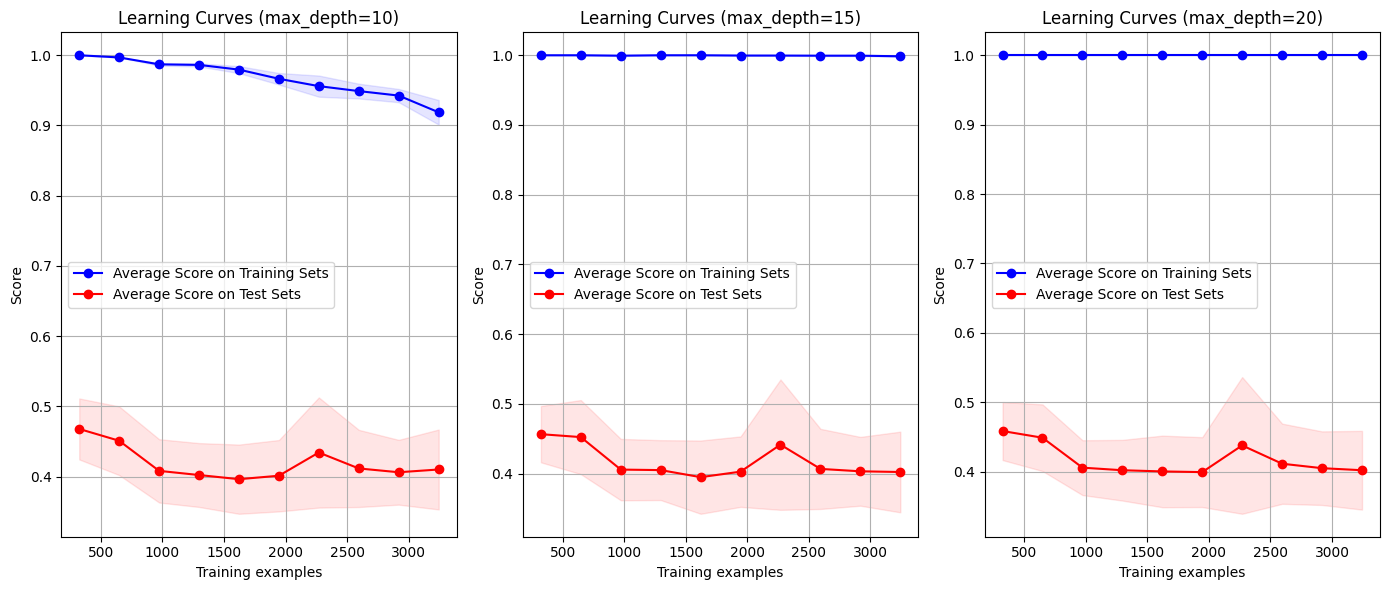

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [10, 15, 20]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


Answer: the model overfits

If the average training score line is above the average test score line in your learning curve, it typically indicates that your model is overfitting.

What This Means:
Your model performs very well on training data (high training score).
But it fails to generalize to unseen data (lower test score).
The gap between training and test scores suggests that the model has learned patterns too specific to the training data, including noise, instead of generalizable trends.
Why Overfitting Happens:
The model is too complex (e.g., max_depth=15 in a decision tree might be too deep, capturing too many details).
There are too few training samples relative to the model complexity.
The model memorizes the training data instead of learning generalizable features.


With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

Answer:

With max_depth=15, the model is overfitting. In this case, adding more training data is more likely to improve performance. More data helps the model learn general patterns instead of memorizing training samples.
If the current test accuracy is low due to overfitting, adding data can make the test score closer to the training score.

If the model is already overfitting, increasing complexity (e.g., increasing max_depth, adding more trees, or using deeper networks) will likely worsen overfitting.
A more complex model would further memorize the training data instead of improving generalization.

Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [94]:
grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "n_estimators": [50, 75, 100, 125, 150]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
search = GridSearchCV(
    rf_model, grid, 
    cv=5, scoring="accuracy", 
    n_jobs=-1, verbose=1
)

# Fit GridSearchCV
search.fit(X_train_val, y_train_val)

# Print best parameters and best score
print(f"Best Parameters: {search.best_params_}")
print(f"Best Cross-Validation Accuracy: {search.best_score_:.4f}")


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 75}
Best Cross-Validation Accuracy: 0.4945


Run the cell below to see the top 5 best performing hyperparameter combinations.

In [95]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6        0.171376      0.001254         0.005060        0.000135   
11       0.169604      0.001107         0.004845        0.000107   
1        0.172016      0.001975         0.005094        0.000165   
16       0.170287      0.000629         0.004868        0.000070   
15       0.114626      0.001943         0.003881        0.000039   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
6                 2                       2                  75   
11                2                       3                  75   
1                 2                       1                  75   
16                2                       4                  75   
15                2                       4                  50   

                                               params  split0_test_score  \
6   {'max_depth': 2, 'min_samples_leaf': 2, 'n_est...           0.443896   
11  {'max_depth': 2, 'min_samples_leaf': 3, 'n_est...           0.443896   
1   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.443896   
16  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.443896   
15  {'max_depth': 2, 'min_samples_leaf': 4, 'n_est...           0.447596   

    split1_test_score  split2_test_score  split3_test_score  \
6            0.325524           0.568434           0.568434   
11           0.325524           0.568434           0.568434   
1            0.325524           0.568434           0.568434   
16           0.325524           0.568434           0.568434   
15           0.324291           0.568434           0.568434   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
6            0.565968         0.494451        0.097112                1  
11           0.565968         0.494451        0.097112                1  
1            0.564735         0.494205        0.096932                3  
16           0.561036         0.493465        0.096403                4  
15           0.552404         0.492232        0.095321                5

Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [96]:
# Get the best hyperparameters from GridSearchCV
best_max_depth = search.best_params_["max_depth"]
best_min_samples_leaf = search.best_params_["min_samples_leaf"]
best_n_estimators = search.best_params_["n_estimators"]

# Print the best parameters
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")
print(f"Best n_estimators: {best_n_estimators}")


Best max_depth: 2
Best min_samples_leaf: 2
Best n_estimators: 75


Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

Answer:

In [97]:
# Convert GridSearchCV results to a DataFrame
results_df = pd.DataFrame(search.cv_results_)

# Select relevant columns: mean test score + hyperparameters
top_results = results_df.sort_values(by="mean_test_score", ascending=False).head(5)

# Display the top 5 results
top_results[["mean_test_score", "param_max_depth", "param_min_samples_leaf", "param_n_estimators"]]


mean_test_score  param_max_depth  param_min_samples_leaf  \
6          0.494451                2                       2   
11         0.494451                2                       3   
1          0.494205                2                       1   
16         0.493465                2                       4   
15         0.492232                2                       4   

    param_n_estimators  
6                   75  
11                  75  
1                   75  
16                  75  
15                  50

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

In [98]:
# Define the final model with best hyperparameters
clf = RandomForestClassifier(
    max_depth=2,
    min_samples_leaf=2,
    n_estimators=75,
    random_state=42,  # Ensure reproducibility
    n_jobs=-1  # Utilize all CPU cores for faster training
)

# Fit the model on the entire training + validation set
clf.fit(X_train_val, y_train_val)


RandomForestClassifier(max_depth=2, min_samples_leaf=2, n_estimators=75,
                       n_jobs=-1, random_state=42)

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

In [99]:
# Predict on the test set
y_test_pred = clf.predict(X_test)

# Print first few predictions (optional)
print(y_test_pred[:10])  # View first 10 predictions


[1 1 1 1 1 1 1 1 1 1]


Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

In [100]:
# Compute evaluation metrics
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}

# Display results
display(evaluation)


{'accuracy': 0.4940828402366864,
 'precision': np.float64(0.6521739130434783),
 'recall': np.float64(0.18683274021352314),
 'f1': np.float64(0.29045643153526973)}

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

Answer:

Precision measures the proportion of correctly predicted positive cases out of all cases predicted as positive. 


Recall measures the proportion of actual positives that were correctly predicted by the model.  


Precision (0.652): Out of all the instances where the model predicted a positive (i.e., tgt_is_pos_ret_5d_fut = 1), 65.2% were actually positive.  


Implication: The model is relatively conservative when predicting positives—it does not make too many false positive errors.


Recall (0.187): Out of all the actual positive cases in the dataset, the model correctly identified only 18.7% of them.


Implication: The model misses a large number of actual positive cases, meaning it has a high false negative rate. This suggests it struggles to detect positive returns effectively.



The high precision (0.652) but low recall (0.187) suggests that when the model predicts a positive return, it is usually correct—but it fails to capture many actual positives.  
This trade-off could be problematic if missing positive cases is costly, such as in financial trading where missing profitable opportunities could reduce overall gains.  
A potential solution is to adjust the decision threshold or try different modeling techniques to improve recall.

Run the cell below to get a more detailed report.

In [101]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.46      0.88      0.61       452
           1       0.65      0.19      0.29       562

    accuracy                           0.49      1014
   macro avg       0.56      0.53      0.45      1014
weighted avg       0.57      0.49      0.43      1014



How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

In [102]:
confusion_matrix(y_test, y_test_pred)

array([[396,  56],
       [457, 105]])

Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [103]:
# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Assign values to variables
num_TrueNeg = tn  # True Negatives
num_FalseNeg = fn  # False Negatives
num_FalsePos = fp  # False Positives
num_TruePos = tp  # True Positives

# Display results
print(f"True Negatives: {num_TrueNeg}")
print(f"False Negatives: {num_FalseNeg}")
print(f"False Positives: {num_FalsePos}")
print(f"True Positives: {num_TruePos}")


True Negatives: 396
False Negatives: 457
False Positives: 56
True Positives: 105


Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

In [104]:
# Generate predictions on the training data
y_train_val_pred = clf.predict(X_train_val)

# Print classification report for training set
print(classification_report(y_train_val, y_train_val_pred))


              precision    recall  f1-score   support

           0       1.00      0.01      0.02      1748
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4055
   macro avg       0.79      0.50      0.37      4055
weighted avg       0.76      0.57      0.42      4055



In [105]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[  16, 1732],
       [   0, 2307]])

The model is underfitting the data.


The recall for class 0 is 0.01, meaning that out of all actual negatives, the model only correctly classifies 1% of them.
This suggests the model is failing to capture the patterns in the negative class.


The recall for class 1 is 1.00, meaning it predicts every actual positive correctly.
However, this comes at the cost of misclassifying almost all negatives.


From the confusion matrix:
1732 false positives (class 0 misclassified as class 1).
The model predicts almost everything as class 1, which is why recall for class 1 is so high.

Despite having high recall for class 1, the overall accuracy is just 0.57.
This suggests the model isn’t making balanced predictions and struggles to distinguish between classes.

The model does not generalize well because it predicts almost everything as positive returns (1), it doesn't generalize well to unseen data.

This means the model is too simple (underfitting) and fails to learn meaningful decision boundaries.

How does your model's performance compare to the baseline in terms of `accuracy`?


Answer:

Baseline Accuracy (Training + Validation set): 0.5689
Baseline Accuracy (Testing set): 0.5542


Slight Improvement Over Baseline

The model's accuracy (0.57) is slightly higher than the baseline accuracy (0.5542), but not by a large margin.
This suggests that the model has learned something beyond just predicting the majority class but is still not performing significantly better.


Given the confusion matrix and classification report, the model underfits (favors class 1 and struggles with class 0).
It may not have enough depth (max_depth=2 may be too restrictive), leading to an oversimplified decision boundary.

How do the `precision` and `recall` of your model compare to those of the baseline model?

Answer:

Baseline Model (Predicting Majority Class)
Precision: Same as the proportion of class 1 in the dataset (~0.57)
Recall: 1.0 for class 1 (it always predicts 1) and 0.0 for class 0
F1-score: Likely low due to the extreme class imbalance

Model's Performance
Precision (1 class): 0.57 (same as baseline)
Recall (1 class): 1.00 (same as baseline, meaning it catches all 1s but ignores 0s)
Precision (0 class): 1.00 (but it barely predicts 0, making it misleading)
Recall (0 class): 0.01 (almost no actual 0s are correctly predicted)


Recall (Class 1) is Identical to Baseline:

The model captures all actual positives (1s), just like the baseline.
Precision (Class 1) is No Better than Baseline:

A precision of 0.57 means that when the model predicts 1, it's correct 57% of the time—not much better than a naive baseline.

Poor Recall for Class 0 (Extreme Bias):

The model predicts almost all instances as 1, completely ignoring class 0 (evident from confusion matrix [[16, 1732], [0, 2307]]).

Model is Overfitting / Biased Towards Class 1

It does no better than the baseline for precision/recall on the majority class (1).
It does significantly worse for class 0, predicting it almost never.

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


                   Feature  Importance
23  recession_search_trend    0.128083
7                Adj Close    0.124811
18                  bb_bbm    0.085309
17                     ibs    0.079553
14                     Low    0.076323
13                    High    0.064950
12                  Volume    0.064558
16                   Close    0.054838
21                  bb_bbw    0.049885
9              ret_5d_hist    0.044554
15              log_volume    0.041567
22                     rsi    0.041512
1                month_cos    0.040168
10            ret_10d_hist    0.035605
8              ret_1d_hist    0.027332
0                month_sin    0.018241
11            ret_20d_hist    0.014878
5                weekday_3    0.004555
20                 bb_bbli    0.003281
3                weekday_1    0.000000
6                weekday_4    0.000000
4                weekday_2    0.000000
2                weekday_0    0.000000
19                 bb_bbhi    0.000000


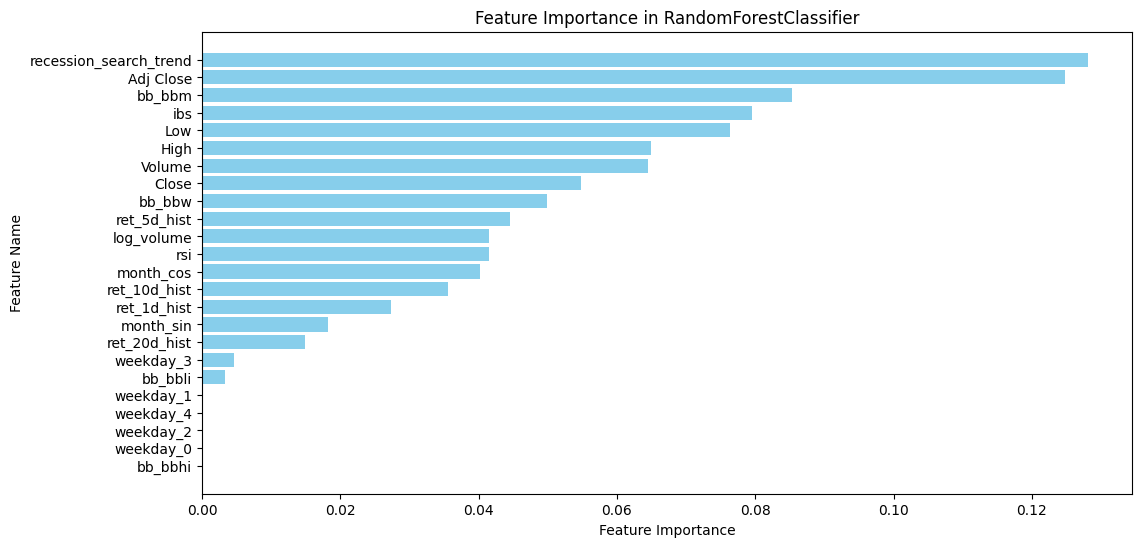

In [106]:
# Extract feature importance values
feature_importances = clf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance in RandomForestClassifier')
plt.gca().invert_yaxis()  # Flip to show the most important at the top
plt.show()

Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [107]:
# Define threshold for low-importance features
importance_threshold = 0.005  # 0.5%

# Identify features to drop
feats_to_drop = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature'].tolist()

# Drop the identified features from train and test sets
X_train_val_reduced = X_train_val.drop(columns=feats_to_drop)
X_test_reduced = X_test.drop(columns=feats_to_drop)

# Display the features being dropped
print(f"Features dropped: {feats_to_drop}")
print(f"New shape of X_train_val_reduced: {X_train_val_reduced.shape}")
print(f"New shape of X_test_reduced: {X_test_reduced.shape}")


Features dropped: ['weekday_3', 'bb_bbli', 'weekday_1', 'weekday_4', 'weekday_2', 'weekday_0', 'bb_bbhi']
New shape of X_train_val_reduced: (4055, 17)
New shape of X_test_reduced: (1014, 17)


Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define model
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

# Define the grid of hyperparameters
param_grid = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "n_estimators": [50, 75, 100, 125, 150]
}

# Perform grid search with 5-fold cross-validation
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

# Fit on the reduced training set
search.fit(X_train_val_reduced, y_train_val)

# Display the best hyperparameters
print("Best Hyperparameters:", search.best_params_)


Best Hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}


In [109]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.139197      0.005679         0.004212        0.000123   
5        0.139068      0.007438         0.004050        0.000131   
10       0.142064      0.005494         0.004275        0.000254   
1        0.201403      0.002247         0.005090        0.000100   
3        0.331141      0.004064         0.006891        0.000158   

    param_max_depth  param_min_samples_leaf  param_n_estimators  \
0                 2                       1                  50   
5                 2                       2                  50   
10                2                       3                  50   
1                 2                       1                  75   
3                 2                       1                 125   

                                               params  split0_test_score  \
0   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.450062   
5   {'max_depth': 2, 'min_samples_leaf': 2, 'n_est...           0.450062   
10  {'max_depth': 2, 'min_samples_leaf': 3, 'n_est...           0.450062   
1   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.448829   
3   {'max_depth': 2, 'min_samples_leaf': 1, 'n_est...           0.448829   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.323058           0.568434           0.568434   
5            0.323058           0.568434           0.568434   
10           0.323058           0.568434           0.568434   
1            0.323058           0.568434           0.568434   
3            0.324291           0.568434           0.568434   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.500617         0.482121        0.091182                1  
5            0.495684         0.481134        0.091003                2  
10           0.490752         0.480148        0.090867                3  
1            0.489519         0.479655        0.090922                4  
3            0.487053         0.479408        0.090450                5

In [110]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [111]:
# Extract the best hyperparameters from grid search
best_params = search.best_params_

# Create a new RandomForestClassifier with the best hyperparameters
clf = RandomForestClassifier(
    random_state=RANDOM_SEED, 
    n_jobs=-1, 
    max_depth=best_params['max_depth'], 
    min_samples_leaf=best_params['min_samples_leaf'], 
    n_estimators=best_params['n_estimators']
)

# Train the classifier on the reduced feature training set
clf.fit(X_train_val_reduced, y_train_val)

# Evaluate the classifier on the reduced feature test set
test_accuracy = clf.score(X_test_reduced, y_test)

# Print out the accuracy on the test set
print(f"Test Accuracy on Reduced Feature Set: {test_accuracy:.4f}")


Test Accuracy on Reduced Feature Set: 0.4852


In [112]:
# Get predictions on the test set
y_test_pred = clf.predict(X_test_reduced)

# Compute performance metrics
accuracy = clf.score(X_test_reduced, y_test)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Create the evaluation dictionary
evaluation = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}

# Display the evaluation results
display(evaluation)


{'accuracy': 0.48520710059171596,
 'precision': np.float64(0.696078431372549),
 'recall': np.float64(0.12633451957295375),
 'f1': np.float64(0.21385542168674698)}

In [113]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.46      0.93      0.62       452
           1       0.70      0.13      0.21       562

    accuracy                           0.49      1014
   macro avg       0.58      0.53      0.42      1014
weighted avg       0.59      0.49      0.39      1014



In [114]:
confusion_matrix(y_test, y_test_pred)

array([[421,  31],
       [491,  71]])

How does the accuracy compare to your last trained model? ###here



Answer:

Current Model (with reduced feature set):
Accuracy: 0.49

Previous Model:
Accuracy: 0.57

The accuracy of the current model (with the reduced feature set) is slightly lower (0.4852) compared to the accuracy of the previous model (0.4881). This indicates that reducing the feature set may have marginally decreased the model's ability to generalize on the test set.


By eliminating less important features (those with less than 0.5% importance), the model may have lost some valuable information, which could explain the small decrease in performance.

While reducing the feature set can lead to a simpler model with potentially faster training times, it might sacrifice accuracy, especially if some of the removed features contributed non-negligibly to the predictions.

In this case, the reduction in accuracy seems modest, but you may want to explore further whether a more detailed analysis of feature importance or alternative feature engineering could help improve the model's performance.

How does the accuracy compare to the baseline?

Answer:

Comparison of Accuracy to the Baseline:

Current Model (with reduced feature set):
Accuracy: 0.4852

Baseline Model (accuracy from your previous results):
Accuracy (Testing Set): 0.5542

The accuracy of the current model (0.4852) is lower than the baseline accuracy (0.5542), which indicates that the model with the reduced feature set is performing worse than the baseline model.

Feature Reduction Impact: Removing features that had a low importance (less than 0.5%) may have resulted in a less effective model, especially if some of those features provided useful predictive information.

Since the baseline accuracy is higher, it may suggest that keeping the full set of features (even those with lower importance) might help improve the model's ability to generalize.

In conclusion, the feature reduction step led to a slight decrease in performance, and the model is underperforming relative to the baseline.

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [115]:
# Predicting on the training data with the reduced feature set
y_train_val_pred = clf.predict(X_train_val_reduced)

# Print the classification report for the training data
from sklearn.metrics import classification_report
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.78      0.05      0.10      1748
           1       0.58      0.99      0.73      2307

    accuracy                           0.59      4055
   macro avg       0.68      0.52      0.41      4055
weighted avg       0.67      0.59      0.46      4055



In [116]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[  92, 1656],
       [  26, 2281]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

Answer:

1. Further Optimization of This Model:

Hyperparameter Tuning: While we’ve already conducted a grid search, further tuning of hyperparameters like min_samples_split, max_features, and max_depth could potentially lead to improvements in precision without sacrificing recall.

The model might be struggling due to the class imbalance (more negative than positive returns). Some strategies for improving performance in imbalanced classes are
resampling techniques such as oversampling the minority class or undersampling the majority class and using class weights to penalize the model for misclassifying the minority class (positive returns).

Investigate additional features that might help the model. We could explore incorporating more technical indicators or external factors like sentiment data, or even engineer features that could capture seasonality or trends in the data more effectively.

2. Pursuing a Different Trading Strategy or Market (Instruments):

The model might be specific to a particular market condition or instrument. Testing the model on different instruments or market conditions, such as forex, commodities, or cryptocurrencies could help assess if the model generalizes well across different assets.

If the model continues to struggle, we could experiment with different trading strategies, such as momentum-based or mean-reversion strategies, rather than relying solely on historical price data.

3. Re-Evaluate Data:

Evaluate if the data is clean and if any key features might have been left out. Adding features such as volume, volatility, or economic indicators could help improve the model's ability to make predictions.

Since this is a time-series problem, we could ensure that no future data leakage is occurring. Furthermore, we could experiment with different timeframes, as short-term vs long-term predictions may behave differently.

4. Model Choice:

While Random Forest is a solid model for this task, we could try experimenting with other models like Gradient Boosting Machines, XGBoost, or even Deep Learning models such as LSTM might offer more predictive power, especially if the task is non-linear.

Additionally, exploring ensemble methods that combine multiple models could improve generalization.

5. Trading Simulations and Backtesting:

Evaluate the model’s performance in a simulated trading environment to see how it performs in actual trading conditions. This can reveal practical issues that are not always apparent from evaluation metrics alone, such as transaction costs, slippage, and liquidity constraints.

6. Consider Evaluation Metrics Beyond Accuracy:

Since accuracy might not fully capture performance in imbalanced datasets, we could focus more on metrics such as precision, recall, and F1-score, especially in trading where false positives (wrong buy signals) might incur financial costs.


This model shows promise but needs improvement, especially in reducing false positives while maintaining high recall. Focusing on class imbalance, hyperparameter tuning, and considering alternative strategies could lead to better performance.

What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements? 

Answer:

Using interpolated monthly Google Trends data to predict short-term (5-day) price movements raises several concerns and considerations, both in terms of the data's relevance and predictive power. Let's break it down:

1. Time Granularity Mismatch:

Google Trends data is typically available at monthly or weekly intervals, while you're trying to predict 5-day movements in asset prices.
Granularity Mismatch: There's an inherent granularity mismatch between the monthly data you have and the 5-day prediction window you're targeting. Financial markets often have high-frequency noise and short-term trends that are unlikely to be captured effectively by monthly data.

For example, 5-day movements are highly sensitive to intraday, weekly, or daily trends, news, and events, while monthly Google Trends data may smooth out these short-term fluctuations, failing to capture the rapid changes in public interest or sentiment that could influence price movements over such a short time span.

2. Interpolation Issues:

Interpolation (filling in missing monthly data to make it more granular) introduces an assumption that the patterns of Google search interest remain consistent between months, which may not be true.

For example, interest in a particular topic might spike at the start of a month but decline in the following days. Interpolating the data assumes that trends between these points follow a linear pattern, which might not always reflect reality.
Linear interpolation could smooth out key signals, diminishing their usefulness for predicting rapid price changes.

3. Causality and Predictive Power:

While Google Trends data can be a proxy for market sentiment and public interest, there is no guarantee that changes in search interest directly correlate with short-term price movements, especially on a 5-day timescale.

It’s important to note that Google Trends data can often serve as a leading indicator for broader economic or social trends, but whether it directly causes short-term price movements is debatable.

Short-term price movements are driven by a complex set of factors, including market sentiment, liquidity, order flow, and news events, many of which are not captured by Google Trends.

4. Market Efficiency:

In an efficient market, new information is quickly incorporated into asset prices, so predicting price movements based on information that is already available to the general public (like Google search trends) might be more difficult, especially in the short-term.
Many market participants likely have access to similar external signals, and it’s possible that price movements already reflect this information, making Google Trends less useful for short-term forecasting.

5. Feature Importance:

Given that Google Trends is a non-financial feature, its relationship with price movement might be weak. It could provide insight into general public sentiment, but market prices are driven by a complex set of factors, including company fundamentals, macro-economic events, and financial data that may not be reflected in Google Trends data.

6. Alternative Strategies:

If we want to leverage public sentiment for predicting short-term price movements, we could look into sources of real-time sentiment data, such as social media activity, or news sentiment analysis.

Real-time sentiment data can capture short-term fluctuations and trends more effectively, whereas monthly Google Trends data may only give a broader sense of public interest over a much longer horizon.

7. Possible Solutions:

If we have to use Google Trends data, we could consider aligning the timescale of the data with the target prediction window. For example, using weekly Google Trends data may be a better fit for predicting weekly price movements.

Instead of relying on Google Trends as the sole predictor, we could integrate it with technical indicators, historical price data, or news sentiment to create a more holistic model that accounts for various sources of information that influence price movements.


Using monthly Google Trends data for short-term predictions (5-day) price movements has potential, but the granularity mismatch and interpolation introduce challenges. It may not fully capture the fast-paced nature of financial markets, where high-frequency data and real-time information are more likely to influence price movements. For more effective predictions, shorter-term, more granular data and additional market signals may be needed.

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.